# ATP Verileri Keşif Analizi (EDA)

Bu notebook `datas/` klasöründeki ATP maç verilerini keşfetmek ve sunum için özetler çıkarmak amacıyla hazırlanmıştır.

Amaçlar:
- Toplam kaç satır (kayıt) ve kaç değişken (sütun) var?
- Veri tipleri dağılımı nedir?
- Eksik değerlerin genel dağılımı nedir?
- Temel kategorik dağılımlar (surface, level, round, vb.)
- Temel sayısal dağılımlar (minutes, yaş, boy, vb.)
- Zaman kapsamı (yıllara göre maç sayısı)


In [12]:
# Imports ve ayarlar
from pathlib import Path
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', 100)
DATA_DIR = Path('../datas').resolve()
DATA_DIR


PosixPath('/Users/kutaykoray/Desktop/ANN/datas')

In [13]:
# Dosya keşfi: atp_matches_*.csv dosyalarını bul
csv_files = sorted([p for p in DATA_DIR.glob('atp_matches_*.csv')])
len(csv_files), csv_files[:5]


(57,
 [PosixPath('/Users/kutaykoray/Desktop/ANN/datas/atp_matches_1968.csv'),
  PosixPath('/Users/kutaykoray/Desktop/ANN/datas/atp_matches_1969.csv'),
  PosixPath('/Users/kutaykoray/Desktop/ANN/datas/atp_matches_1970.csv'),
  PosixPath('/Users/kutaykoray/Desktop/ANN/datas/atp_matches_1971.csv'),
  PosixPath('/Users/kutaykoray/Desktop/ANN/datas/atp_matches_1972.csv')])

In [14]:
# Yıllara göre dosya sayısı özeti
def year_from_name(p: Path):
    try:
        return int(p.stem.split('_')[-1])
    except Exception:
        return None
years = [year_from_name(p) for p in csv_files]
summary_years = pd.Series(years).value_counts().sort_index()
summary_years.head(), summary_years.tail(), (summary_years.index.min(), summary_years.index.max())


(1968    1
 1969    1
 1970    1
 1971    1
 1972    1
 Name: count, dtype: int64,
 2020    1
 2021    1
 2022    1
 2023    1
 2024    1
 Name: count, dtype: int64,
 (np.int64(1968), np.int64(2024)))

In [15]:
# Sütun kümesini çıkarmak için meta okuma (hızlı)
all_cols = set()
sample_cols = {}
for p in csv_files[:10]:  # ilk birkaç dosyadan sütun örnekle
    try:
        df0 = pd.read_csv(p, nrows=0, low_memory=False)
        all_cols.update(df0.columns.tolist())
        sample_cols[p.name] = df0.columns.tolist()
    except Exception as e:
        print('Hata:', p.name, e)
len(all_cols), list(sorted(all_cols))[:20]


(49,
 ['best_of',
  'draw_size',
  'l_1stIn',
  'l_1stWon',
  'l_2ndWon',
  'l_SvGms',
  'l_ace',
  'l_bpFaced',
  'l_bpSaved',
  'l_df',
  'l_svpt',
  'loser_age',
  'loser_entry',
  'loser_hand',
  'loser_ht',
  'loser_id',
  'loser_ioc',
  'loser_name',
  'loser_rank',
  'loser_rank_points'])

In [16]:
# Toplam satır sayısını chunk'larla hızlıca hesapla (RAM dostu)
def count_rows(files, chunksize=200_000):
    total = 0
    for p in files:
        try:
            for chunk in pd.read_csv(p, chunksize=chunksize, low_memory=False):
                total += len(chunk)
        except Exception as e:
            print('Hata sayarken:', p.name, e)
    return total
total_rows = count_rows(csv_files)
total_cols = len(all_cols)
print('Toplam Kayıt (satır):', total_rows)
print('Toplam Değişken (sütun):', total_cols)


Toplam Kayıt (satır): 194996
Toplam Değişken (sütun): 49


In [17]:
# Veri tipleri: örnek birleştirme ile dtype çıkarımı (örneklem)
def sample_concat(files, max_files=5, max_rows_per_file=50_000):
    dfs = []
    for p in files[:max_files]:
        try:
            df = pd.read_csv(p, nrows=max_rows_per_file, low_memory=False)
            dfs.append(df)
        except Exception as e:
            print('Hata okurken:', p.name, e)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()
sample_df = sample_concat(csv_files, max_files=6, max_rows_per_file=60_000)
sample_df.shape, sample_df.head(2)


((22413, 49),
   tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
 0  1968-2029       Dublin   Grass       32.0             A      19680708   
 1  1968-2029       Dublin   Grass       32.0             A      19680708   
 
    match_num  winner_id  winner_seed winner_entry      winner_name  \
 0        270     112411          NaN          NaN       Doug Smith   
 1        271     126914          NaN          NaN  Louis Pretorius   
 
   winner_hand  winner_ht winner_ioc  winner_age  loser_id  loser_seed  \
 0           U        NaN        AUS         NaN    110196         NaN   
 1           R        NaN        RSA         NaN    209536         NaN   
 
   loser_entry       loser_name loser_hand  loser_ht loser_ioc  loser_age  \
 0         NaN  Peter Ledbetter          U       NaN       IRL       24.0   
 1         NaN  Maurice Pollock          U       NaN       IRL        NaN   
 
      score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  \
 0

In [18]:
# Dtype özeti
dtype_summary = sample_df.dtypes.value_counts().rename_axis('dtype').reset_index(name='count')
dtype_summary


,dtype,count
0,float64,30
1,object,14
2,int64,5


In [19]:
# Eksik değer analizi (örneklemde)
na_counts = sample_df.isna().sum().sort_values(ascending=False)
na_pct = (sample_df.isna().mean() * 100).sort_values(ascending=False)
na_df = pd.DataFrame({'na_count': na_counts, 'na_pct': na_pct})
na_df.head(20)


,na_count,na_pct
l_df,22413,100.000000
l_1stWon,22413,100.000000
l_2ndWon,22413,100.000000
l_1stIn,22413,100.000000
l_SvGms,22413,100.000000
w_ace,22413,100.000000
w_df,22413,100.000000
w_svpt,22413,100.000000
w_1stIn,22413,100.000000
l_bpSaved,22413,100.000000


In [20]:
# Kategorik özetler (varsa): surface, tourney_level, round
for col in ['surface', 'tourney_level', 'round']:
    if col in sample_df.columns:
        display(pd.DataFrame(sample_df[col].value_counts().head(10)).rename(columns={col: 'count'}))
    else:
        print(f'Kolon yok: {col}')


,count
surface,
Clay,7923
Grass,5223
Hard,5105
Carpet,2342


,count
tourney_level,
A,17655
G,2492
D,1147
M,1119


,count
round,
R32,6500
R64,4825
R16,3864
QF,2243
RR,1652
R128,1487
SF,1176
F,615
BR,51


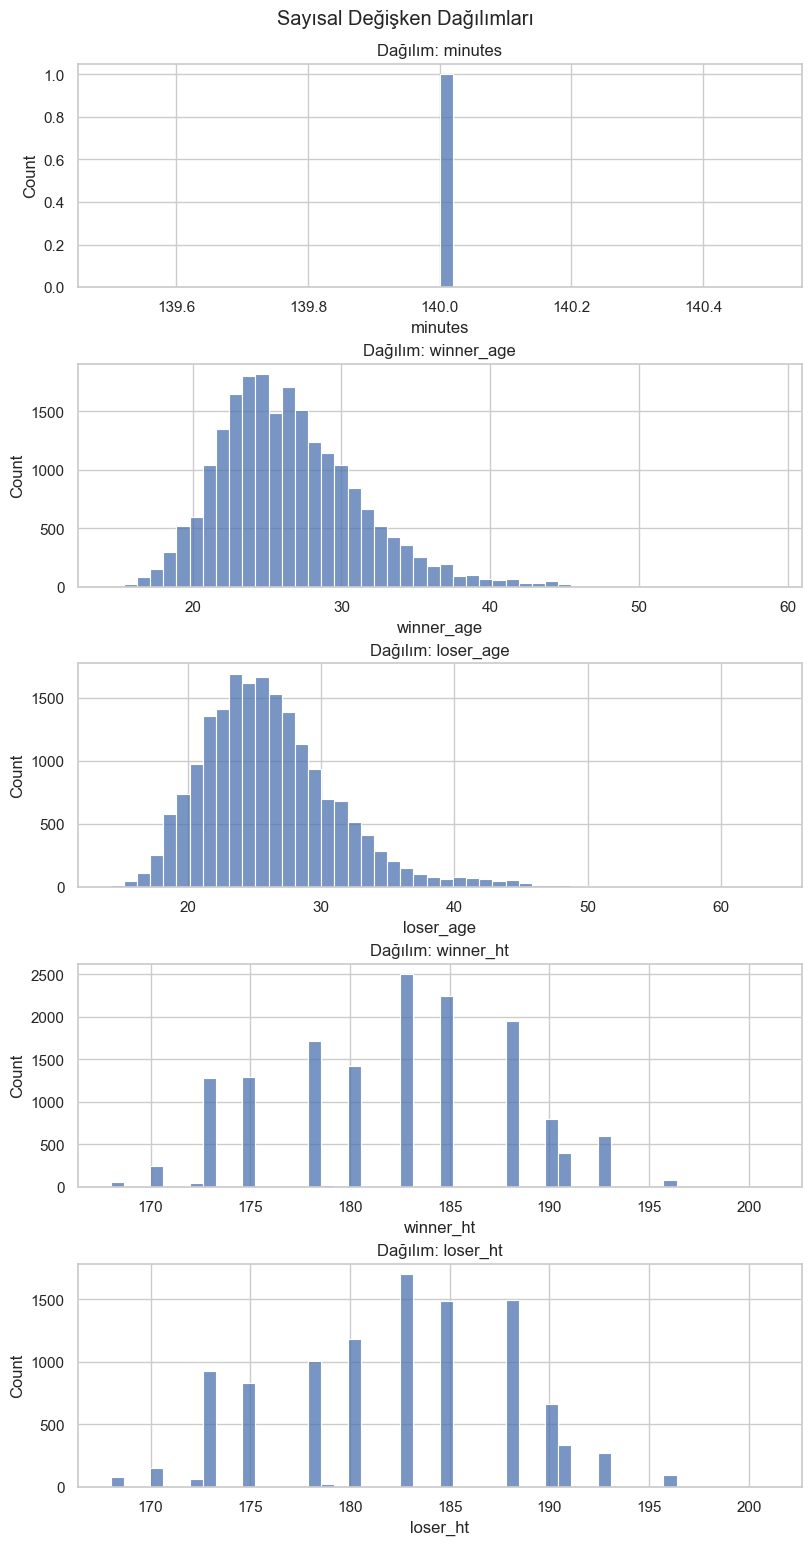

In [21]:
# Sayısal dağılımlar (varsa): minutes, winner_age, loser_age, winner_ht, loser_ht
num_cols = [c for c in ['minutes', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht'] if c in sample_df.columns]
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 3*max(1, len(num_cols))), constrained_layout=True)
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    sns.histplot(sample_df[col].dropna(), bins=50, ax=ax, kde=False)
    ax.set_title(f'Dağılım: {col}')
fig.suptitle('Sayısal Değişken Dağılımları', y=1.02)
plt.show()


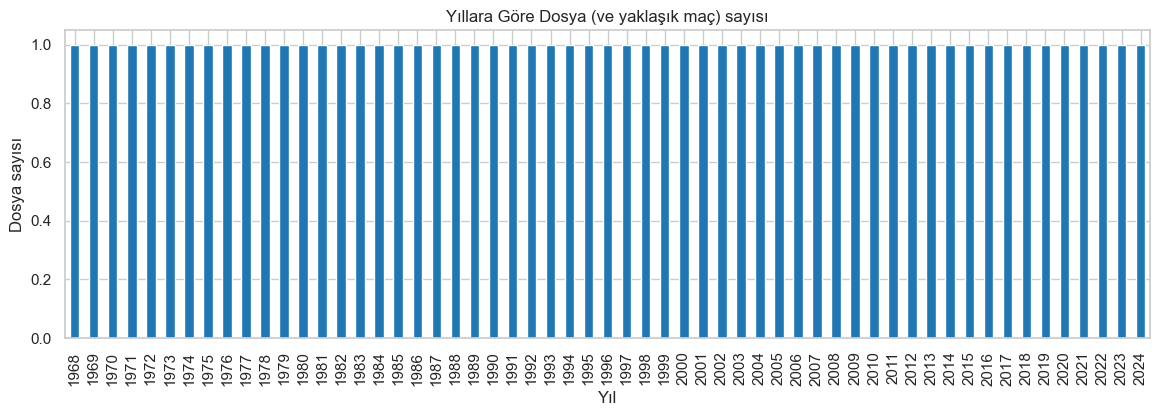

In [22]:
# Zaman kapsamı: yıllara göre maç sayısı (dosya adına göre)
year_counts = pd.Series([y for y in years if y is not None]).value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(14,4), color='#1f77b4')
ax.set_title('Yıllara Göre Dosya (ve yaklaşık maç) sayısı')
ax.set_xlabel('Yıl')
ax.set_ylabel('Dosya sayısı')
plt.show()


## Örneklemden görselleştirmeler ve basit çıkarımlar
Bu bölüm `sample_df` üzerinde hızlı görselleştirmeler ve birkaç temel içgörü üretir. Grafikler örneklem (tüm veri değil) içindir.

In [23]:
# Örneklem boyutu ve hızlı ön izleme
print('sample_df shape:', sample_df.shape)
display(sample_df.head(3))

sample_df shape: (22413, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32.0,A,19680708,270,112411,NaN,NaN,Doug Smith,U,NaN,AUS,NaN,110196,NaN,NaN,Peter Ledbetter,U,NaN,IRL,24.0,6-1 7-5,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32.0,A,19680708,271,126914,NaN,NaN,Louis Pretorius,R,NaN,RSA,NaN,209536,NaN,NaN,Maurice Pollock,U,NaN,IRL,NaN,6-1 6-1,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32.0,A,19680708,272,209523,NaN,NaN,Cecil Pedlow,U,NaN,IRL,NaN,209535,NaN,NaN,John Mulvey,U,NaN,IRL,NaN,6-2 6-2,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


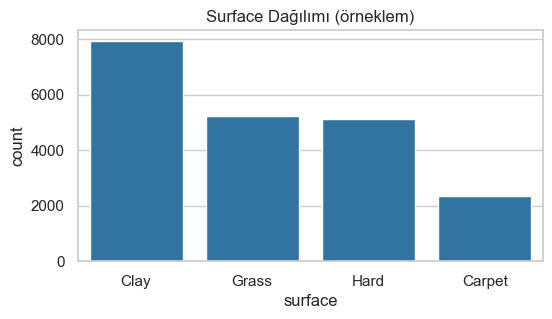

In [24]:
# 1) Yüzey (surface) dağılımı
if 'surface' in sample_df.columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=sample_df, x='surface', order=sample_df['surface'].value_counts().index, color='#1f77b4')
    plt.title('Surface Dağılımı (örneklem)')
    plt.xlabel('surface')
    plt.ylabel('count')
    plt.xticks(rotation=0)
    plt.show()
else:
    print('surface kolonu yok')

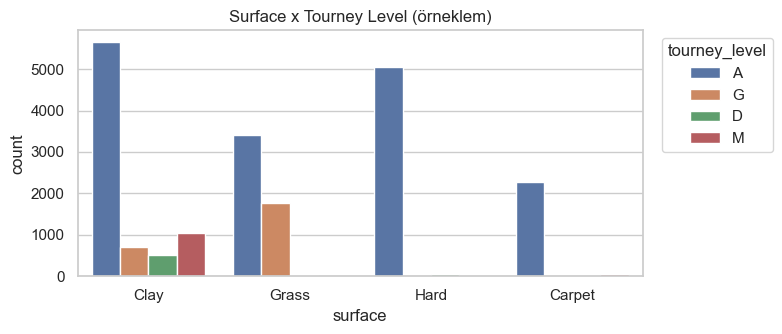

In [25]:
# 2) Surface x Tourney Level (sayım)
if {'surface','tourney_level'}.issubset(sample_df.columns):
    plt.figure(figsize=(8,3.5))
    order_s = sample_df['surface'].value_counts().index
    order_l = sample_df['tourney_level'].value_counts().index
    sns.countplot(data=sample_df, x='surface', hue='tourney_level', order=order_s, hue_order=order_l)
    plt.title('Surface x Tourney Level (örneklem)')
    plt.xlabel('surface')
    plt.ylabel('count')
    plt.legend(title='tourney_level', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('Gerekli kolonlar yok: surface, tourney_level')

In [ ]:
# 3) Maç süresi (minutes) - surface bazında boxplot
if {'minutes','surface'}.issubset(sample_df.columns):
    dfm = sample_df[['minutes','surface']].dropna().copy()
    if not dfm.empty:
        # Aykırı etkisini azaltmak için winsorize benzeri kırpma
        q1, q99 = dfm['minutes'].quantile([0.01, 0.99])
        dfm['minutes_clip'] = dfm['minutes'].clip(q1, q99)
        plt.figure(figsize=(8,3.5))
        sns.boxplot(data=dfm, x='surface', y='minutes_clip', order=dfm['surface'].value_counts().index)
        plt.title('Minutes by Surface (örneklem, 1-99% kırpılmış)')
        plt.xlabel('surface')
        plt.ylabel('minutes (clip)')
        plt.show()
    else:
        print('minutes ya da surface için yeterli veri yok')
else:
    print('Gerekli kolonlar yok: minutes, surface')

In [ ]:
# 4) Yıllık trend (tourney_date -> year) örneklem içinde
if 'tourney_date' in sample_df.columns:
    years_from_date = None
    s = sample_df['tourney_date'].dropna()
    try:
        # tip: bazı dosyalarda YYYYMMDD int/str olabilir
        s = s.astype(str).str.slice(0,4).astype(int)
        years_from_date = s
    except Exception as e:
        print('Yıl çıkarılamadı:', e)
    if years_from_date is not None and not years_from_date.empty:
        cnt = years_from_date.value_counts().sort_index()
        plt.figure(figsize=(12,3.5))
        cnt.plot(kind='bar', color='#1f77b4')
        plt.title('Örneklemde Yıllara Göre Maç Sayısı (tourney_date)')
        plt.xlabel('Yıl')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
    else:
        print('Yıl dağılımı için yeterli veri yok')
else:
    print('tourney_date kolonu yok')

In [ ]:
# 5) En çok maç kazanan oyuncular (örneklem)
if 'winner_name' in sample_df.columns:
    top_winners = sample_df['winner_name'].value_counts().head(20)
    plt.figure(figsize=(8,5))
    top_winners.sort_values().plot(kind='barh', color='#2ca02c')
    plt.title('En Çok Maç Kazanan Oyuncular (Top 20, örneklem)')
    plt.xlabel('count')
    plt.ylabel('winner_name')
    plt.tight_layout()
    plt.show()
    display(top_winners)
else:
    print('winner_name kolonu yok')

In [ ]:
# 6) Sıralama farkı analizi (upset oranı)
rank_cols = {'winner_rank','loser_rank'}
if rank_cols.issubset(sample_df.columns):
    r = sample_df[list(rank_cols)].dropna().copy()
    if not r.empty:
        r['rank_diff'] = r['loser_rank'] - r['winner_rank']  # + ise favori kazanmış, - ise upset
        plt.figure(figsize=(7,3.5))
        sns.histplot(r['rank_diff'], bins=50, color='#9467bd')
        plt.axvline(0, color='red', linestyle='--', linewidth=1)
        plt.title('Rank Difference (loser_rank - winner_rank)')
        plt.xlabel('rank_diff')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
        upset_rate = (r['rank_diff'] < 0).mean() * 100
        print(f'Upset oranı (winner rank sayısal olarak daha kötü -> rank_diff < 0): {upset_rate:.1f}%')
    else:
        print('Rank farkı için yeterli veri yok')
else:
    print('Gerekli kolonlar yok: winner_rank, loser_rank')

In [ ]:
# 7) Basit korelasyon ısı haritası (seçilmiş sayısal sütunlar)
num_candidates = [
    'minutes','best_of','draw_size',
    'winner_age','loser_age','winner_ht','loser_ht',
    'winner_rank','loser_rank','winner_rank_points','loser_rank_points'
]
cols_exist = [c for c in num_candidates if c in sample_df.columns]
if len(cols_exist) >= 2:
    dfc = sample_df[cols_exist].copy()
    if dfc.dropna(how='all').shape[0] > 0:
        corr = dfc.corr(numeric_only=True)
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=False, cmap='vlag', center=0, square=True)
        plt.title('Korelasyon Isı Haritası (örneklem)')
        plt.tight_layout()
        plt.show()
    else:
        print('Korelasyon için yeterli sayısal/eksiksiz veri yok')
else:
    print('Korelasyon için en az iki sayısal sütun gerekli')

## Notlar
- Toplam satır sayısı chunk'lı sayımla hesaplanır (RAM dostu).
- Değişken sayısı ilk birkaç dosyadan sütun kümesi çıkarılarak tahmin edilir.
- Eksik değer ve dağılım analizleri örneklem üzerinde yapılır; istenirse tüm veri için de chunk'lı genişletilebilir.
